<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep convolutional net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an IPython notebook via Learning Suite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 20% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracies
* 10% Reach 85% validation accuracy from parts 1-3
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

* Watch tutorial

**DONE:**

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropyLoss function. Do not use PyTorch's implementation of cross entropy loss (F.cross_entropy or nn.CrossEntropyLoss) for your re-implementation of cross entropy loss. You may use PyTorch's functional implemenation of 2D convolution in your Conv2D module.

**TODO:**

**DONE:**
* CrossEntropyLoss 
* Conv2D
___

### Part 2
Implement three initialization strategies: Xe initialization
(sometimes called Xavier), orthogonal initialization, and uniform random initialization.
You can specify which strategy you want to use with a parameter.



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**

**DONE:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform



In [2]:
class CrossEntropyLoss(nn.Module):
 def forward(self,y_hat,y_truth):
   return (torch.logsumexp(y_hat,dim=1) - y_hat[:,y_truth]).mean()

class Conv2d(nn.Module):
  def __init__(self,in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None,dist_type='uniform'):
    self.__dict__.update(locals())
    super(Conv2d,self).__init__()

    self.weight = Parameter(torch.Tensor(out_channels,
                                         in_channels,
                                         *kernel_size))
    self.bias = Parameter(torch.Tensor(out_channels))

    self.bias.data.uniform_(0,0)

    if dist_type == 'uniform':
      self.weight.data.uniform_(-1,1)
    elif dist_type == 'xavier' or dist_type == 'Xavier' or dist_type == 'Xe' or dist_type == 'xe':
      self.weight.data.normal_(0,  np.sqrt(2/(in_channels + out_channels)))
    elif dist_type == 'orthogonal':
      #out, in, kernel size
      X = np.random.random((out_channels, in_channels * kernel_size[0] * kernel_size[1]))
      U, _, Vt = np.linalg.svd(X, full_matrices=False)
      self.weight.data = torch.from_numpy((U@Vt).reshape((out_channels, in_channels, kernel_size[0], kernel_size[1])).astype(np.float32))

  def forward(self,x):
    return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


In [3]:
class ConvNetwork(nn.Module):
  def __init__(self, dataset,dist_type='uniform'):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = 10

    self.net = nn.Sequential(
        Conv2d(c, 10, (3,3), padding=(1,1),dist_type=dist_type),
        nn.ReLU(),                                         
        Conv2d(10, output, (28,28),padding=(0,0),dist_type=dist_type),
    )

  def forward(self,x):
    return self.net(x).squeeze(2).squeeze(2)


In [4]:
# Initialize Datasets
# Use the dataset class you created in lab2
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self,root,train=True):
    self.data = datasets.FashionMNIST(root,train=train, transform = transforms.ToTensor(), download=True)
  
  def __getitem__(self,i):
    x,y = self.data[i]
    return x,y

  def __len__(self):
    return len(self.data)

train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist')
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist',train=False)

# Initialize DataLoaders
train_loader = DataLoader(train_dataset,
                          batch_size=42,
                          pin_memory=True)
val_loader = DataLoader(val_dataset,
                        batch_size=42,
                        pin_memory=True)



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /tmp/fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /tmp/fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /tmp/fashionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /tmp/fashionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw



In [48]:
losses_total = []
validations_total = []
accuracies_total = []
Vaccuracies_total = []

def arg_softmax(y_):
 """
 Takes in an array of arrays of activated outputs, converts each into probabilities using softmax,
 and returns an array of indices of guesses (loc of highest prob for each array)
 """
 guesses = []
 #run through softmax
 for y in y_:
     exp = torch.exp(y)
     probs = exp/torch.sum(exp)
 
     #append index of greatest probability
     guesses.append(int(torch.argmax(probs)))
     
 return torch.Tensor(guesses)

def get_accuracy(y_hat,targets):
 """
 Takes in two tensor arrays - guesses and targets - and returns the percentage of overlap (accuracy)
 """
 #get guess indices
 guesses = arg_softmax(y_hat).cuda()

 #count number of overlaps
 overlap = float(sum(guesses == targets))
 
 #return accuracy
 return overlap/len(guesses)


# Run your training and validation loop and collect stats
for DIST_TYPE in ['uniform','xe','orthogonal']:
  #reset losses and validations lists, the whole lists will be appended to losses_total and validations_total, respectively
  losses = []
  validations = []
  accuracies = []
  Vaccuracies = []

  # Initialize Model
  model = ConvNetwork(train_dataset,dist_type=DIST_TYPE)
  model = model.cuda()
  
  # Initialize Objective and Optimizer and other parameters
  objective = CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(),lr = 1e-4)
  
  if DIST_TYPE == 'uniform':
    num_eps = 20
  else:
    num_eps = 40
  for epoch in range(num_eps):
   
   loop = tqdm(total=len(train_loader),position=0,leave=False)
 
   for batch, (x,y_truth) in enumerate(train_loader):
     x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)
     optimizer.zero_grad()
     y_hat = model(x)
     accuracy = get_accuracy(y_hat,y_truth)
     accuracies.append(accuracy)

     loss = objective(y_hat,y_truth)
     loss.backward()
     losses.append(loss.item())

     optimizer.step()
 
     loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch, loss, accuracy))
     loop.update(1)

     #validation loss and accuracy
     if batch % 500 == 0:
       res = np.array([  [objective( model(x.cuda()),  y.cuda()).item(), get_accuracy(model(x.cuda()), y.cuda())]
                     for x, y in val_loader  ])
       val = res[:,0].mean()
       vacc = res[:,1].mean()
       validations.append((len(losses), val))
       Vaccuracies.append((len(losses), vacc))

       
     
  loop.close()
 
  losses_total.append(losses)
  validations_total.append(validations)
  Vaccuracies_total.append(Vaccuracies)
  accuracies_total.append(accuracies)

In [49]:
#turn validations into arrays for plotting purposes
na0 = np.array(Vaccuracies_total[0])
na1 = np.array(Vaccuracies_total[1])
na2 = np.array(Vaccuracies_total[2])
nv0 = np.array(validations_total[0])
nv1 = np.array(validations_total[1])
nv2 = np.array(validations_total[2])


___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

Once you've experimented with multiple network setups and the different initialization strategies, plot the best-performing experiments with each initialization strategy. You should be able to exceed 85% accuracy on the validation set in at least one of the plotted experiments.

**TODO:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time for each initialization strategy (w/ accurate graph title and axes lables)
* Plot experiment results with 85% or better validation accuracy
* Print out number of parameters in the model 

**DONE:**


In [8]:
def plot_vloss(epochS=1,epochF=None,which='all'):
 """plot validation losses starting at epochS and ending at epochF (starting index at 1)
 epochS: starting epoch indexed at 1
 epochF: final epoch indexed at 1
 which: string or list of strings identifying which initialization(s) to plot
 """
 if epochF is None: 
   epochF = -1
   idf = False #identifier boolean for whether a final epoch was passed in
 else: 
   epochF -= 1
   idf = True
 epochS -= 1
 if which == 'all':
  plt.plot(nv0[epochS*3:epochF*3,0],nv0[epochS*3:epochF*3,1],color='tab:blue',label='uniform')
  plt.scatter(nv0[epochS*3:epochF*3,0],nv0[epochS*3:epochF*3,1],color='tab:blue')
  plt.plot(nv1[epochS*3:epochF*3,0],nv1[epochS*3:epochF*3,1],color='tab:orange',label='xavier')
  plt.scatter(nv1[epochS*3:epochF*3,0],nv1[epochS*3:epochF*3,1],color='tab:orange')
  plt.plot(nv2[epochS*3:epochF*3,0],nv2[epochS*3:epochF*3,1],color='tab:green',label='orthogonal')
  plt.scatter(nv2[epochS*3:epochF*3,0],nv2[epochS*3:epochF*3,1],color='tab:green')
 else:
   if 'uniform' in which:
     plt.plot(nv0[epochS*3:epochF*3,0],nv0[epochS*3:epochF*3,1],color='tab:blue',label='uniform')
     plt.scatter(nv0[epochS*3:epochF*3,0],nv0[epochS*3:epochF*3,1],color='tab:blue')
   if 'xe' in which:
     plt.plot(nv1[epochS*3:epochF*3,0],nv1[epochS*3:epochF*3,1],color='tab:orange',label='xavier')
     plt.scatter(nv1[epochS*3:epochF*3,0],nv1[epochS*3:epochF*3,1],color='tab:orange')
   if 'orthogonal' in which:
     plt.plot(nv2[epochS*3:epochF*3,0],nv2[epochS*3:epochF*3,1],color='tab:green',label='orthogonal')
     plt.scatter(nv2[epochS*3:epochF*3,0],nv2[epochS*3:epochF*3,1],color='tab:green')
 plt.legend()
 plt.title('validation losses with different weight initializations')
 plt.xlabel('epoch')
 plt.ylabel('loss')

 #if a final epoch was passed in
 if idf: xticks = np.arange(epochS+1,epochF+2)
 #otherwise just go through all 50 epochs
 else: xticks = np.arange(epochS+1,51)
 plt.xticks(np.linspace( nv1[:,0][epochS*3], nv1[:,0][(epochF)*3], len(xticks)), xticks  )

 plt.show()

In [9]:
def plot_vacc(epochS=1,epochF=None,which='all'):
 """Plot validation accuracies starting at epochS and ending at epochF (starting index at 1)
 epochS: starting epoch indexed at 1
 epochF: final epoch indexed at 1
 which: string or list of strings identifying which initializations to plot
 """
 if epochF is None: 
   epochF=-1
   idf = False #identifier boolean for whether a final epoch was passed in
 else: 
   epochF -= 1
   idf = True
 epochS -= 1

 if which == 'all':
  plt.plot(na0[epochS*3:epochF*3,0],na0[epochS*3:epochF*3,1],color='tab:blue',label='uniform')
  plt.scatter(na0[epochS*3:epochF*3,0],na0[epochS*3:epochF*3,1],color='tab:blue')
  plt.plot(na1[epochS*3:epochF*3,0],na1[epochS*3:epochF*3,1],color='tab:orange',label='xavier')
  plt.scatter(na1[epochS*3:epochF*3,0],na1[epochS*3:epochF*3,1],color='tab:orange')
  plt.plot(na2[epochS*3:epochF*3,0],na2[epochS*3:epochF*3,1],color='tab:green',label='orthogonal')
  plt.scatter(na2[epochS*3:epochF*3,0],na2[epochS*3:epochF*3,1],color='tab:green')
 else:
   if 'uniform' in which:
     plt.plot(na0[epochS*3:epochF*3,0],na0[epochS*3:epochF*3,1],color='tab:blue',label='uniform')
     plt.scatter(na0[epochS*3:epochF*3,0],na0[epochS*3:epochF*3,1],color='tab:blue')
   if 'xe' in which:
     plt.plot(na1[epochS*3:epochF*3,0],na1[epochS*3:epochF*3,1],color='tab:orange',label='xavier')
     plt.scatter(na1[epochS*3:epochF*3,0],na1[epochS*3:epochF*3,1],color='tab:orange')
   if 'orthogonal' in which:
     plt.plot(na2[epochS*3:epochF*3,0],na2[epochS*3:epochF*3,1],color='tab:green',label='orthogonal')
     plt.scatter(na2[epochS*3:epochF*3,0],na2[epochS*3:epochF*3,1],color='tab:green')

 plt.legend()
 plt.title('validation accuracies with different weight initializations')
 plt.xlabel('epoch')
 plt.ylabel('accuracy')
 
 #if a final epoch was passed in
 if idf: xticks = np.arange(epochS+1,epochF+2)
 #otherwise just go through all 50 epochs
 else: xticks = np.arange(epochS+1,51)
 plt.xticks(np.linspace( na1[:,0][epochS*3], na1[:,0][(epochF)*3], len(xticks)), xticks  )

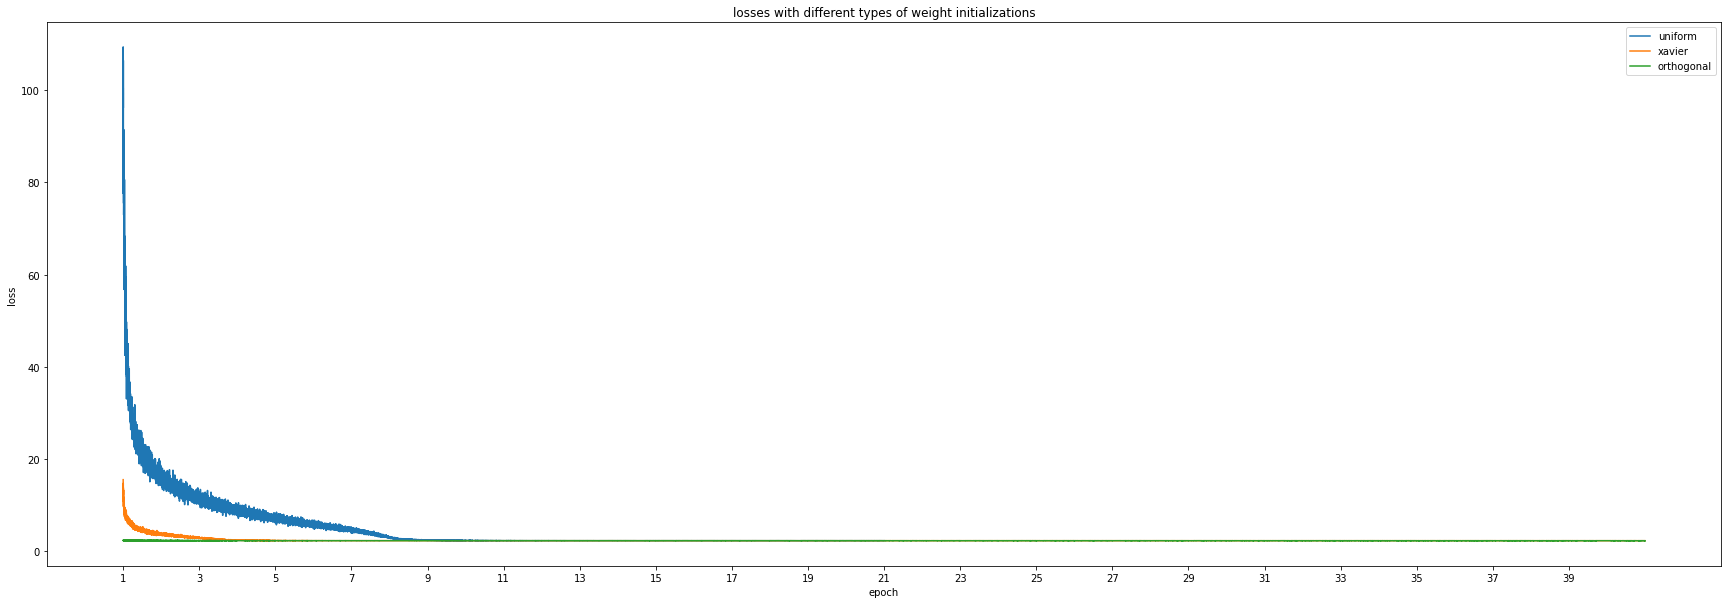

In [50]:
#plotting all losses together
plt.rcParams.update({'font.size': 10}) #make font size big
plt.rcParams["figure.figsize"] = (30,10) #make plots big
plt.plot(range(len(losses_total[0])),losses_total[0],label='uniform')
plt.plot(range(len(losses_total[1])),losses_total[1],label='xavier')
plt.plot(range(len(losses_total[2])),losses_total[2],label='orthogonal')
plt.title('losses with different types of weight initializations')
plt.xlabel('epoch')
plt.xticks(np.arange(0,len(losses_total[1]),2*len(train_loader)), np.arange(1,51,2) )
plt.ylabel('loss')
plt.legend()
plt.show()

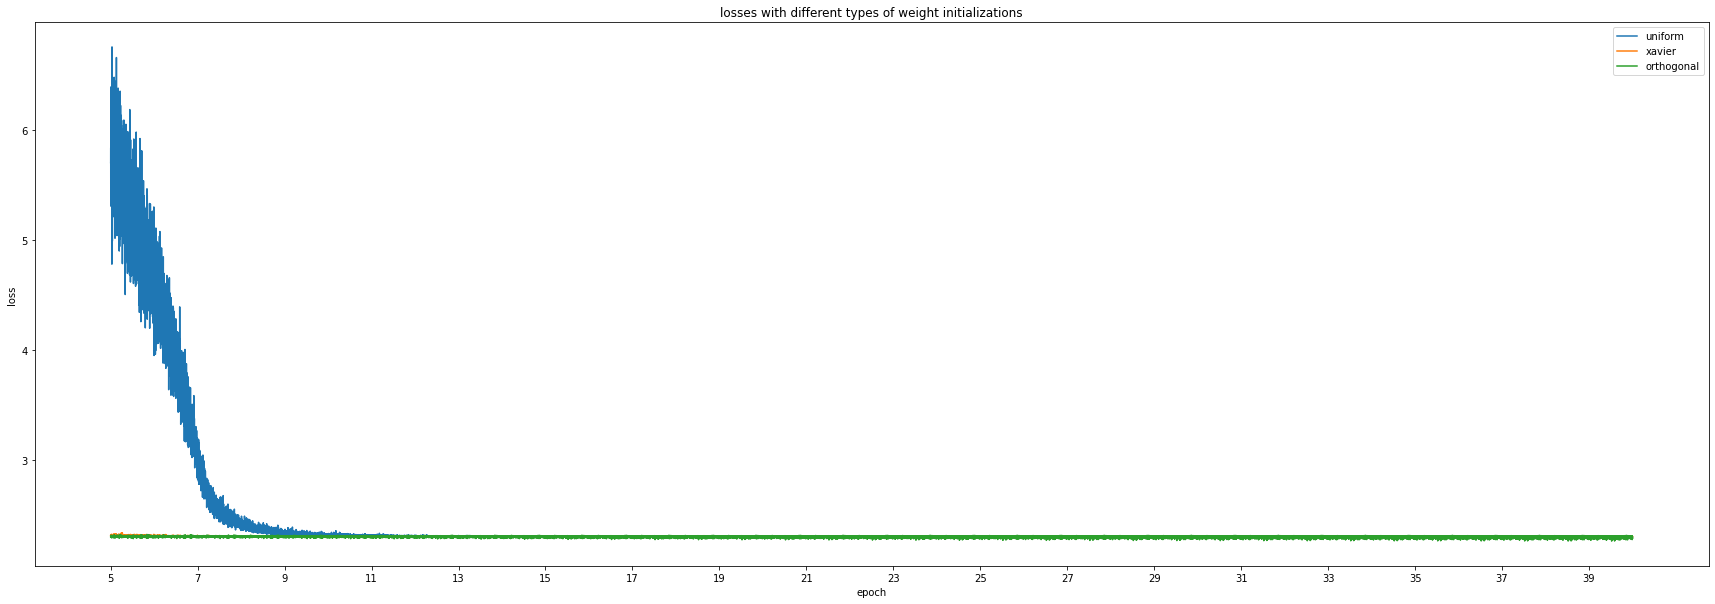

In [58]:
#Plotting all losses together starting at epoch 5
plt.plot(range(len(losses_total[0][5*len(train_loader):])),losses_total[0][5*len(train_loader):],label='uniform')
plt.plot(range(len(losses_total[1][5*len(train_loader):])),losses_total[1][5*len(train_loader):],label='xavier',zorder=2)
plt.plot(range(len(losses_total[2][5*len(train_loader):])),losses_total[2][5*len(train_loader):],label='orthogonal')
plt.title('losses with different types of weight initializations')
plt.xlabel('epoch')
plt.xticks(np.arange(0,len(losses_total[1][5*len(train_loader):]),2*len(train_loader)), np.arange(5,51,2) )
plt.ylabel('loss')
plt.legend()
plt.show()

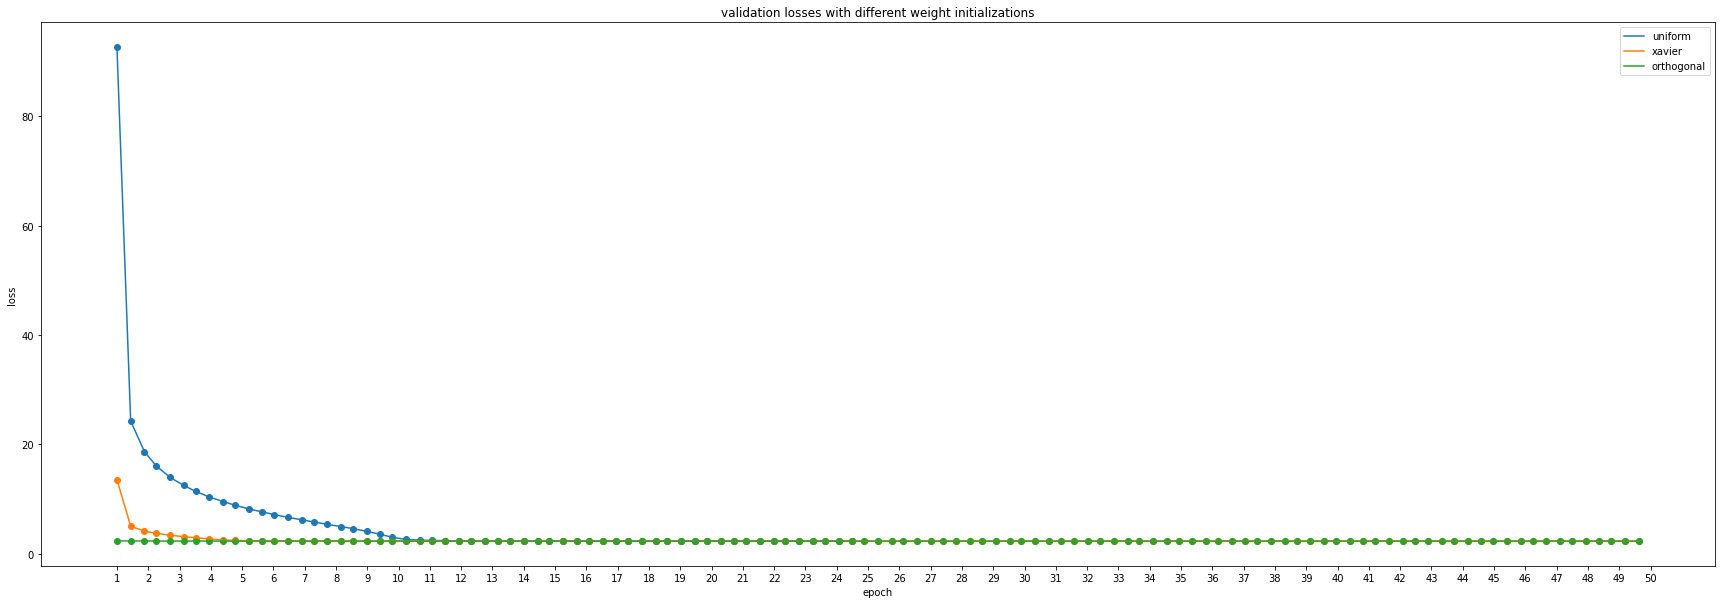

In [52]:
#plotting all validation losses together
plot_vloss()

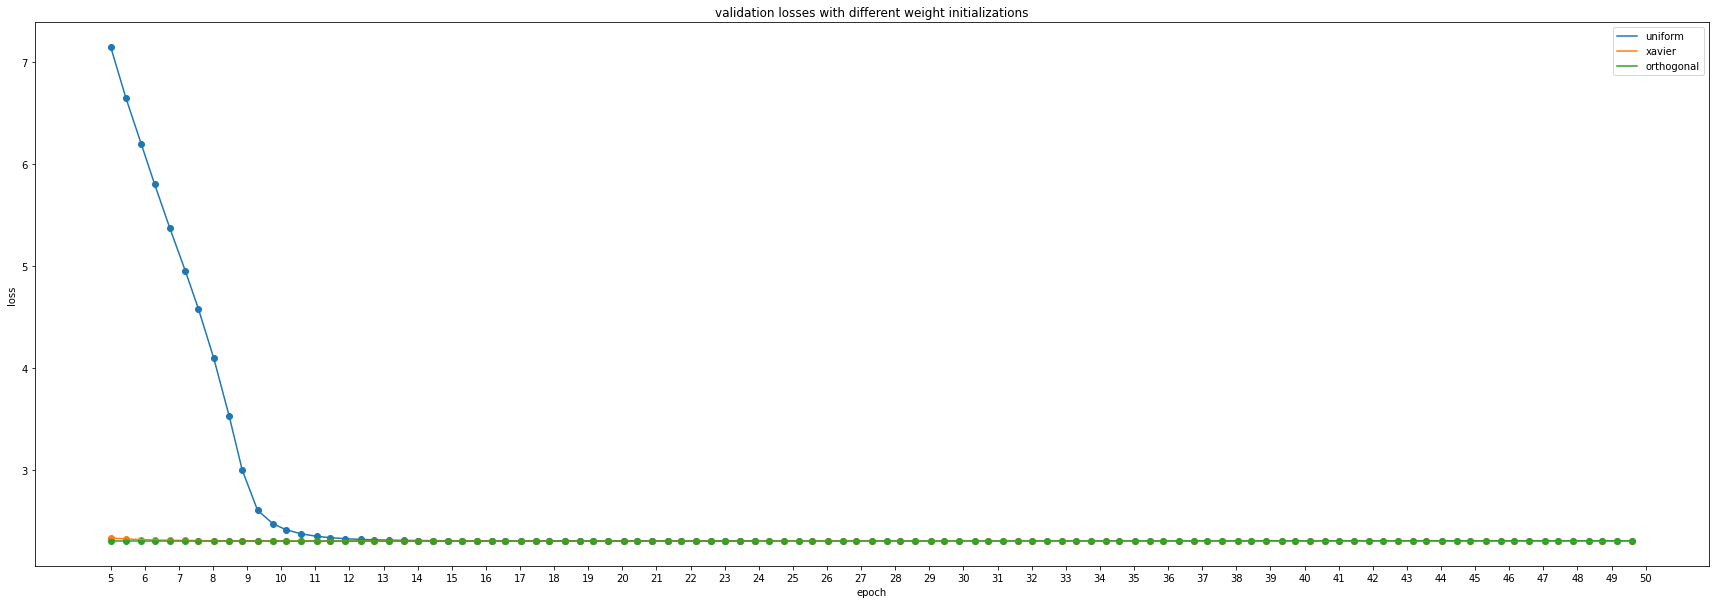

In [53]:
#Plotting all validation losses together starting at epoch 5
plot_vloss(5)

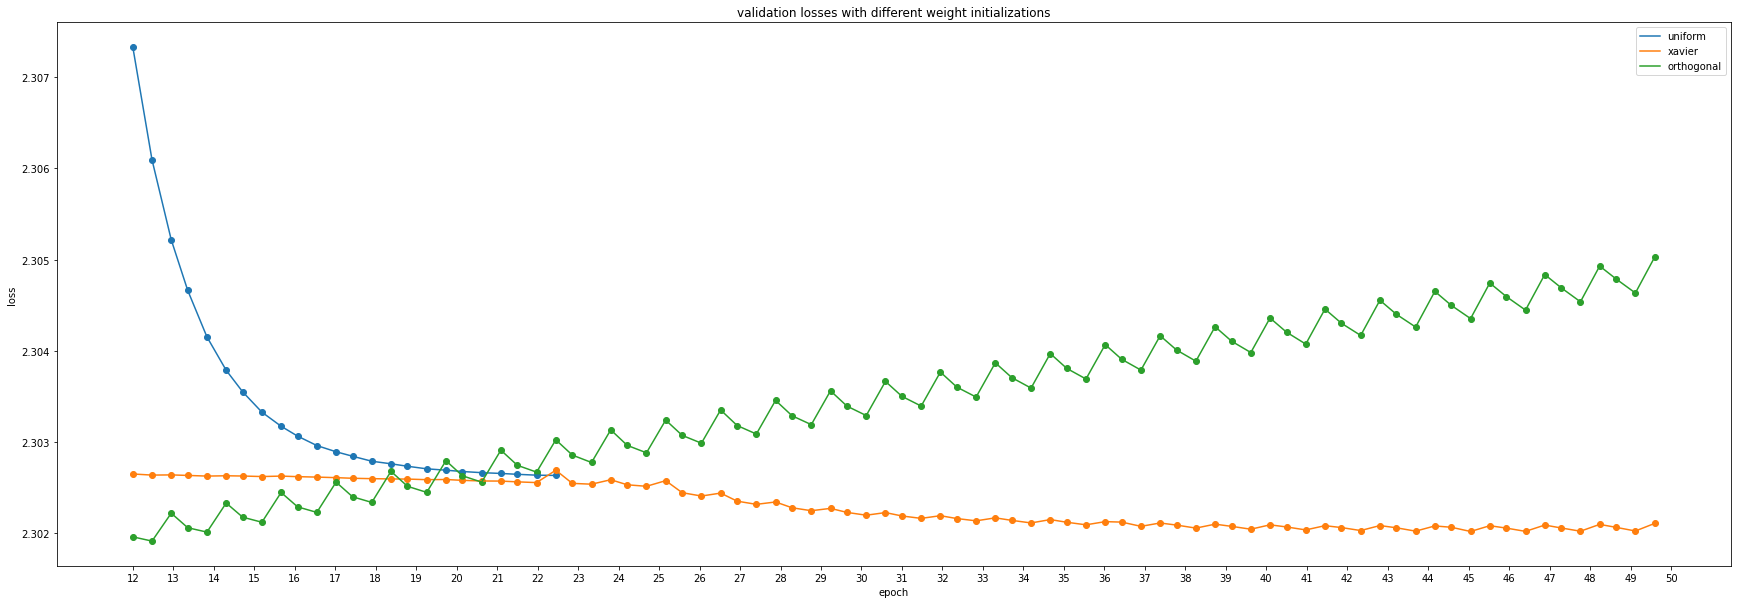

In [55]:
#plotting all validation losses starting at epoch 12
plot_vloss(12)

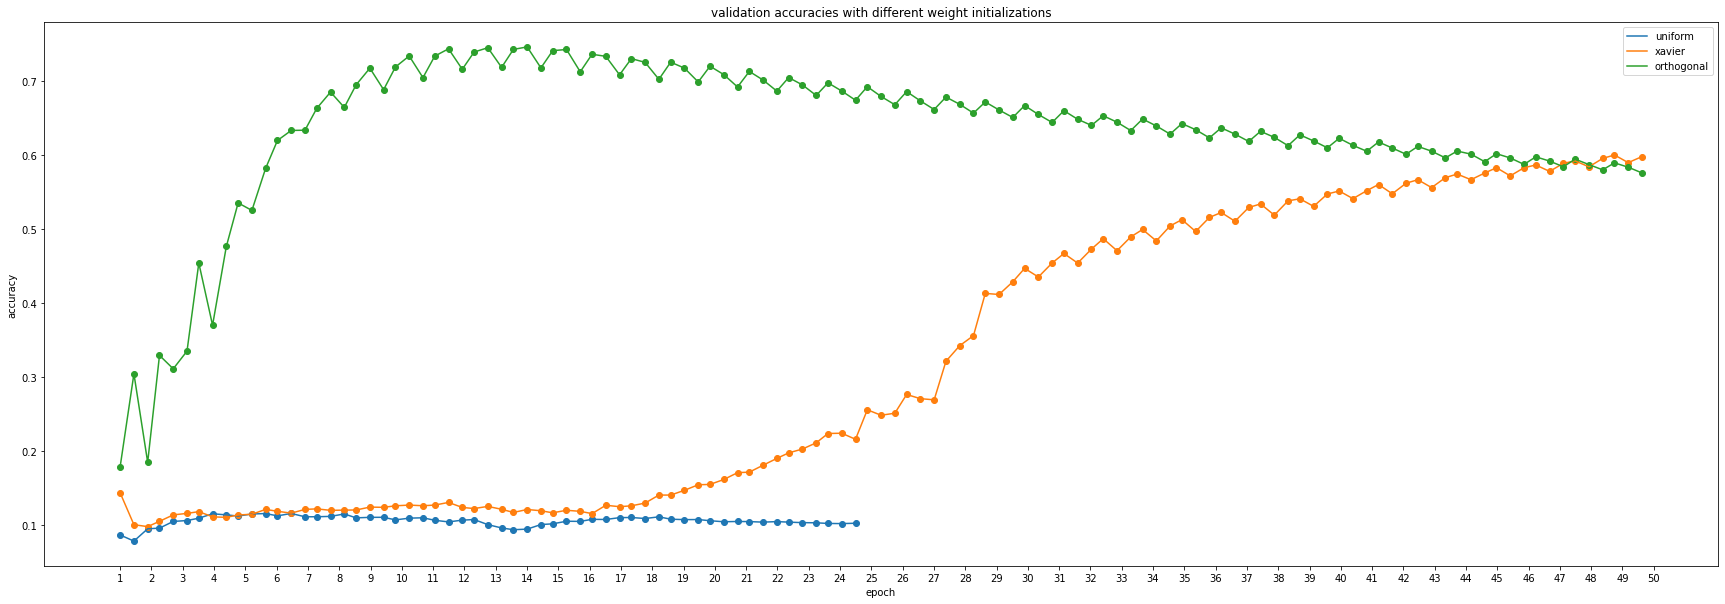

In [59]:
#plotting all validation accuracies together
plot_vacc()

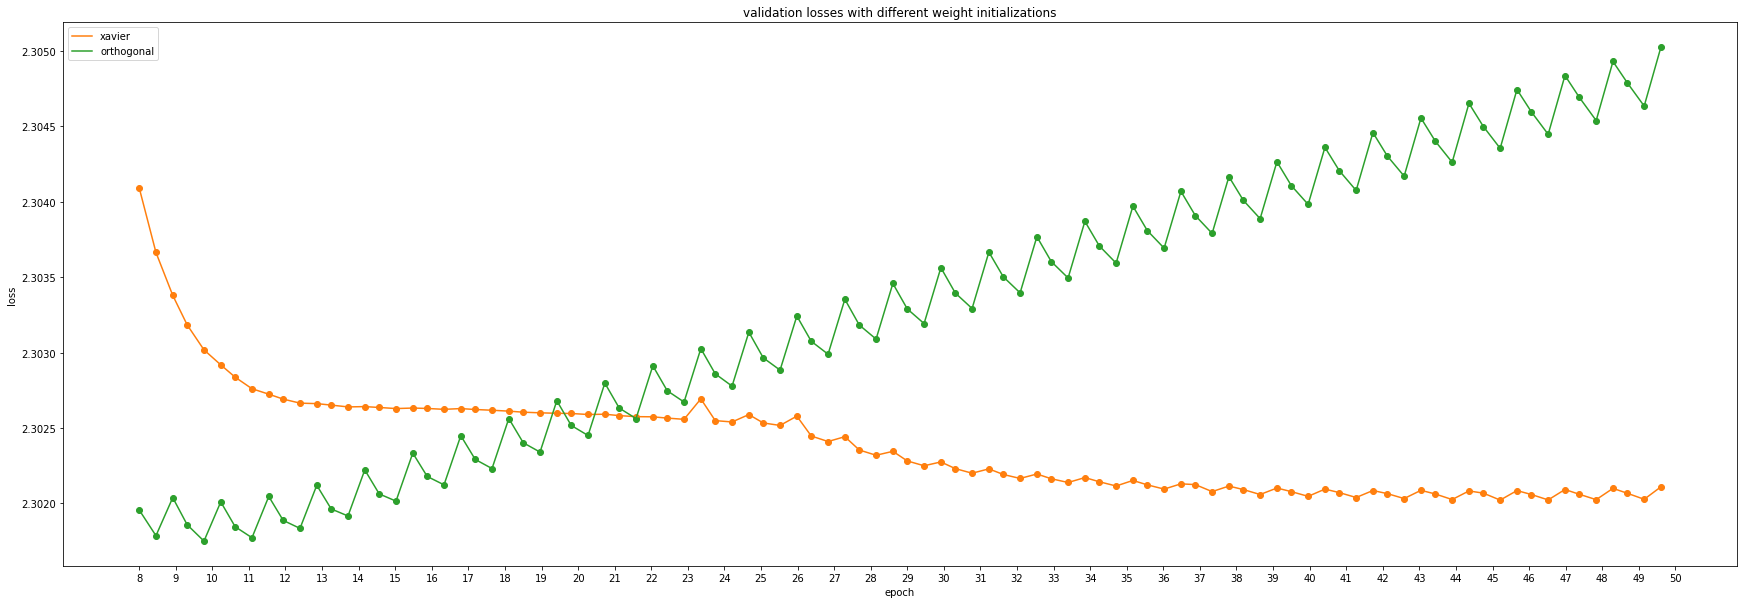

In [60]:
#validation loss with just orth and xe starting at epoch 8
plot_vloss(8,which=['orthogonal','xe'])

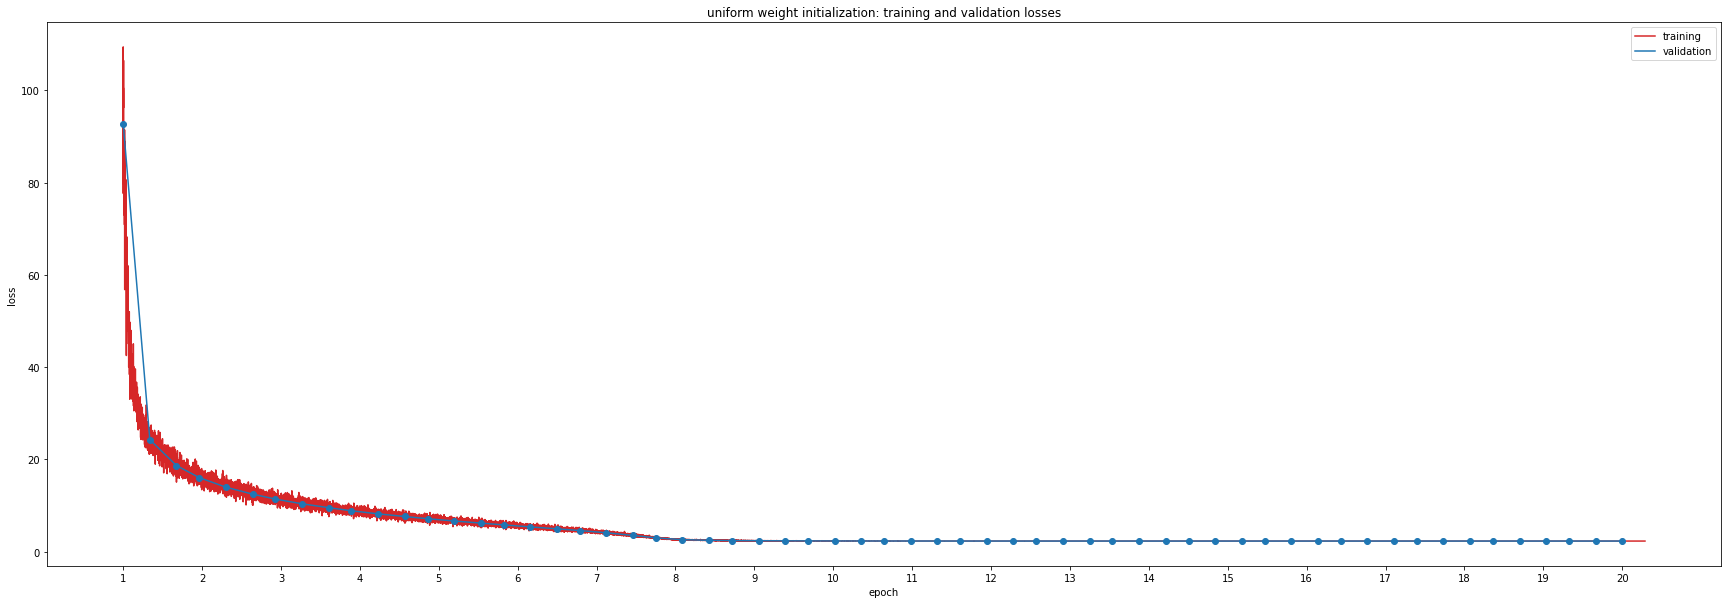

In [61]:
# Go back up and try a few different networks and initialization strategies
# Plot training and validation loss for uniform initialization
plt.plot(losses_total[0],label='training',color='tab:red',zorder=0)
plt.plot( nv0[:,0],     nv0[:,1],label='validation',color='tab:blue',zorder=1)
plt.scatter(nv0[:,0],nv0[:,1],color='tab:blue',zorder=2)
xticks = np.arange(1,21)
plt.xticks(np.linspace( nv0[:,0][0], nv0[:,0][59], len(xticks)), xticks  )
plt.title('uniform weight initialization: training and validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

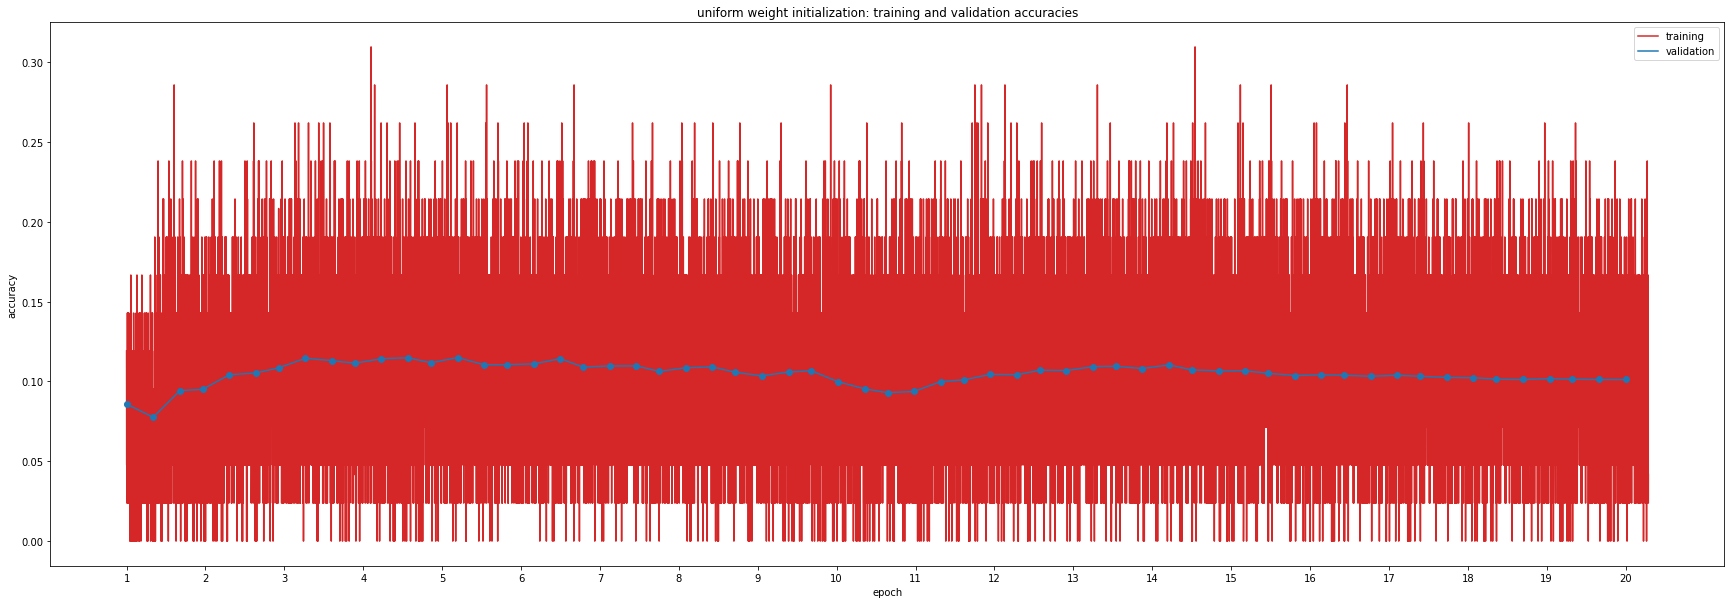

In [64]:
# Plot training and validation accuracy for uniform initialization
plt.plot(accuracies_total[0],label='training',color='tab:red',zorder=0)
plt.plot(na0[:,0],na0[:,1],label='validation',color='tab:blue',zorder=1)
plt.scatter(na0[:,0],na0[:,1],color='tab:blue',zorder=2)
xticks = np.arange(1,21)
plt.xticks(np.linspace( na0[:,0][0], na0[:,0][59], len(xticks)), xticks  )
plt.title('uniform weight initialization: training and validation accuracies')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

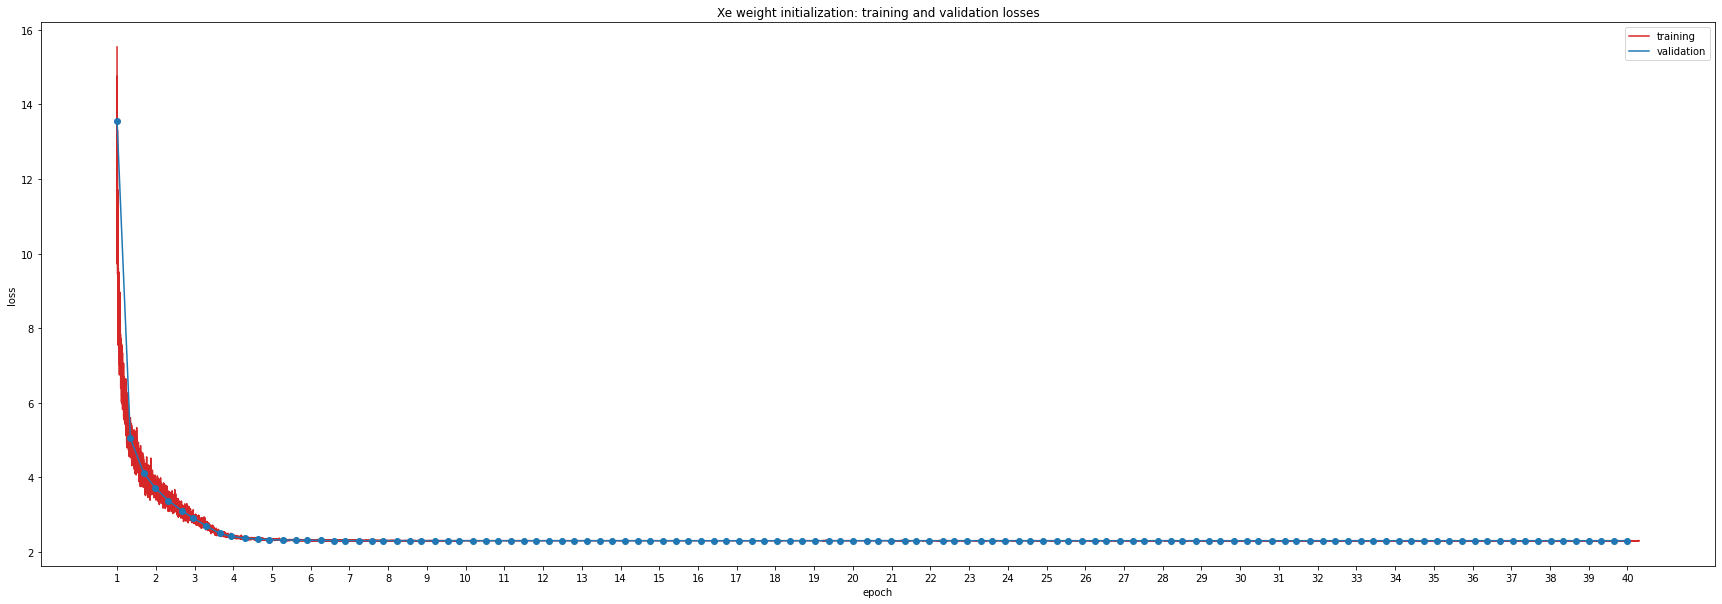

In [76]:
# Plot training and validation loss for Xe initialization
plt.plot(losses_total[1],label='training',color='tab:red',zorder=0)
plt.plot(nv1[:,0],nv1[:,1],label='validation',color='tab:blue',zorder=1)
plt.scatter(nv1[:,0],nv1[:,1],color='tab:blue',zorder=2)
xticks = np.arange(1,41)
plt.xticks(np.linspace( nv1[:,0][0], nv1[:,0][-1], len(xticks)), xticks  )
plt.title('Xe weight initialization: training and validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

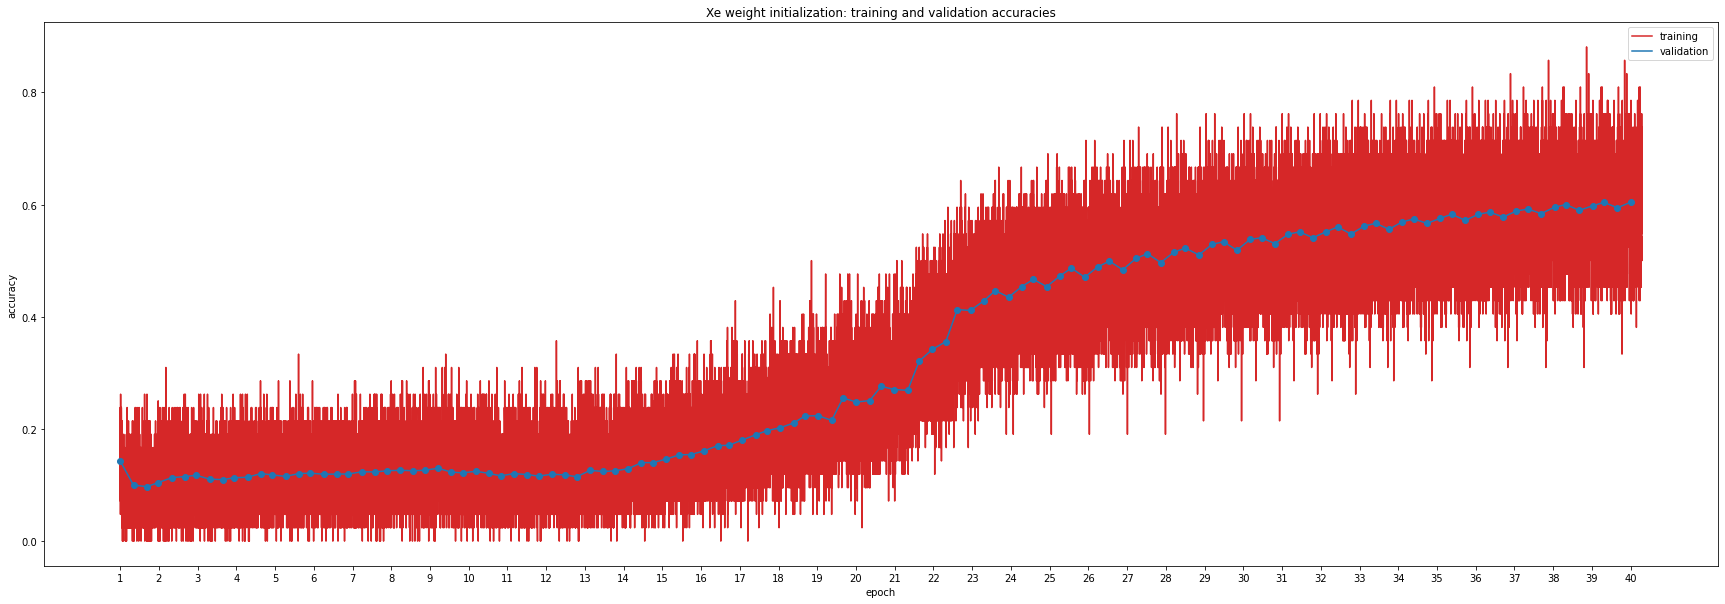

In [75]:
# Plot training and validation accuracy for Xe initialization
plt.plot(accuracies_total[1],label='training',color='tab:red',zorder=0)
plt.plot(na1[:,0],na1[:,1],label='validation',color='tab:blue',zorder=1)
plt.scatter(na1[:,0],na1[:,1],color='tab:blue',zorder=2)
xticks = np.arange(1,41)
plt.xticks(np.linspace( na1[:,0][0], na1[:,0][-1], len(xticks)), xticks  )
plt.title('Xe weight initialization: training and validation accuracies')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

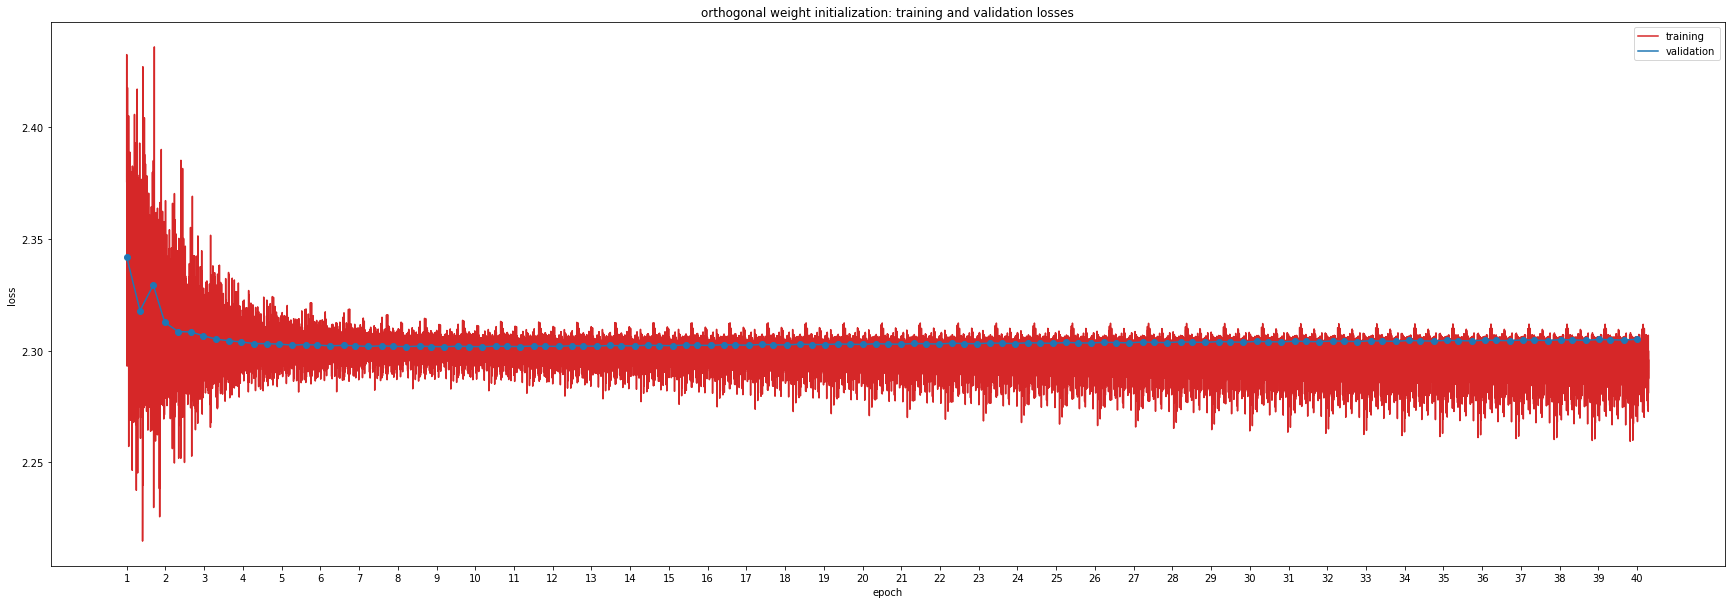

In [74]:
# Plot training and validation loss for orthogonal initialization
plt.plot(losses_total[2],label='training',color='tab:red',zorder=0)
plt.plot(nv2[:,0],nv2[:,1],label='validation',color='tab:blue',zorder=1)
plt.scatter(nv2[:,0],nv2[:,1],color='tab:blue',zorder=2)
xticks = np.arange(1,41)
plt.xticks(np.linspace( nv2[:,0][0], nv2[:,0][-1], len(xticks)), xticks  )
plt.title('orthogonal weight initialization: training and validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

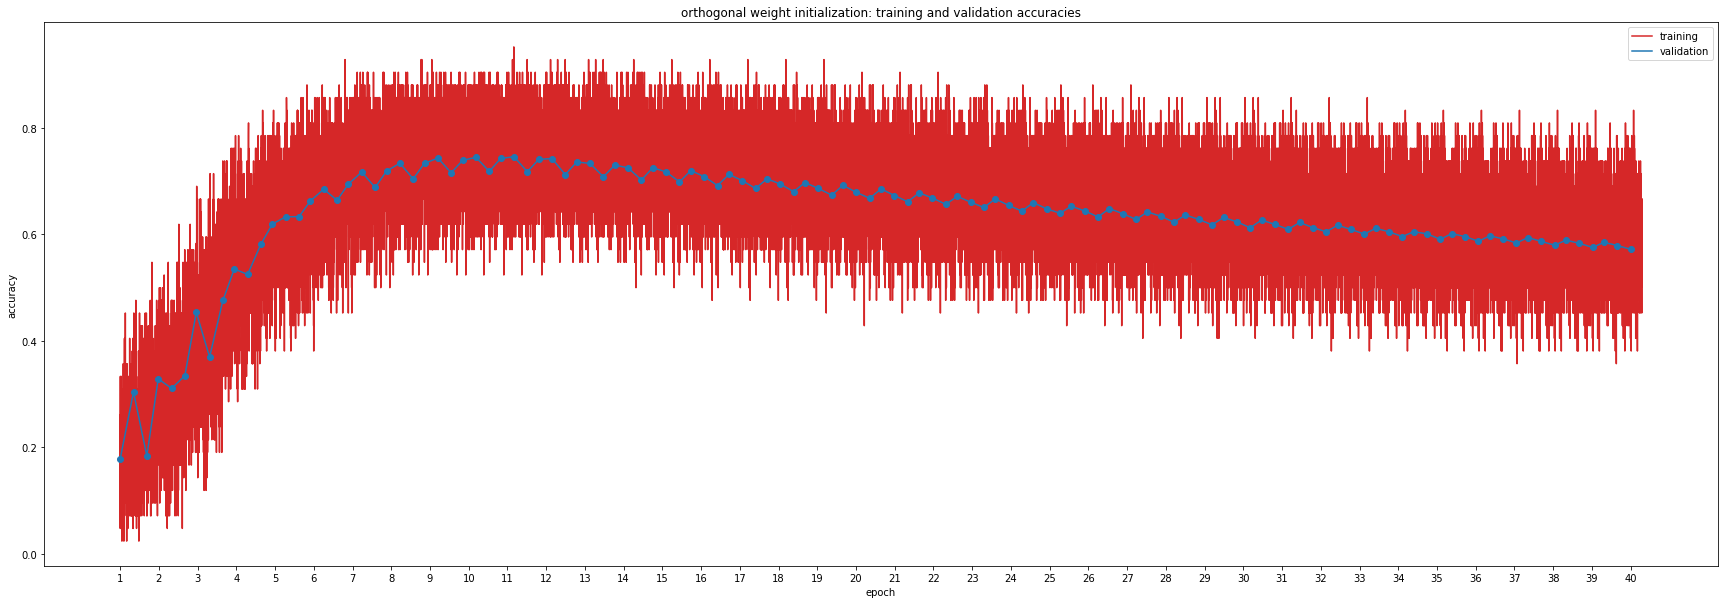

In [73]:
# Plot training and validation accuracy for orthogonal initialization
plt.plot(accuracies_total[2],label='training',color='tab:red',zorder=0)
plt.plot(na2[:,0],na2[:,1],label='validation',color='tab:blue',zorder=1)
plt.scatter(na2[:,0],na2[:,1],color='tab:blue',zorder=2)
xticks = np.arange(1,41)
plt.xticks(np.linspace( na2[:,0][0], na2[:,0][-1], len(xticks)), xticks  )
plt.title('orthogonal weight initialization: training and validation accuracies')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [72]:
# Compute and print the number of parameters in the model
num_params = sum(np.prod(p.size()) for p in model.parameters())
print(num_params)

78510


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(3,3), padding=(1,1))**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **(out_channels=65, kernel_size=(3,3), padding=(2,2))**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **(out_channels=7, kernel_size=(3,3), padding=(6,6))**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5, 5), padding=(2, 2))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5, 5), padding=(3, 3))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5, 5), padding=(9, 9))**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernel_size=(5, 3), padding=(1, 0))**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5, 3), padding=(2, 1))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5, 3), padding=(3, 2))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5, 3), padding=(9, 8))**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **kernel_size=(2,4), padding=(0,0)**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **kernel_size(1,1), padding=(0,0)**

**TODO:**



**DONE:**
* Answer all the questions above 

In [79]:
# Write some test code for checking the answers for these problems (example shown in the video)
# Let the original size of the matrix be (h0,w0). The relationship is as follows:
#   Barring any padding, the kernel of size (k1,k2) will be able to move 
#     h0-k1 times vertically + 1 for the initial setting of the kernel, giving an output height h1 = h0 - k1 + 1
#     w0-k2 times horizontally + 1 for the initial setting of the kernel, giving an output w1 = w0 - k2 + 1
#   Padding acts like increasing the original matrix size, giving an "original" size of (h0+2p1,w+2p2) ## coefficient of 2 because the padding is applied to both sides
#   Since we are given the input, output, and kernel sizes, we can make the relationship h1 = h0 + p1 - k1 + 1 -->  p1 = (h1 - h0 + k1 - 1)/2
#   Likewise with the width expression for p2

def calc_padding(h0,w0,h1,w1,k1,k2):
  p1 = (h1 - h0 + k1 - 1)/2
  p2 = (w1 - w0 + k2 - 1)/2
  return (p1,p2)

In [80]:
#last parts of each section:
print(calc_padding(10,10,20,20,3,3))
print(calc_padding(10,10,24,24,5,5))
print(calc_padding(10,10,24,24,5,3))

(6.0, 6.0)
(9.0, 9.0)
(9.0, 8.0)


In [81]:
# For the last problem, ideally we want to find a kernel size that lets us have 0 padding
#   By setting p1 = p2 = 0, this gives us the expressions
#     k1 = 1 + h0 - h1, and likewise for k2
def best_kernel(h0,w0,h1,w1):
  k1 = 1 + h0 - h1
  k2 = 1 + w0 - w1
  return (k1, k2)

In [82]:
# answers to final 2 problems
print(best_kernel(10,10,9,7))
print(best_kernel(10,10,10,10))

(2, 4)
(1, 1)


NOTE THAT I DID WRITE CODE TO CHECK MY ANSWERS, AS INSTRUCTED.